# Monte-Carlo simulation model

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns
import faker
import isodate
from datetime import date

In [3]:
plt.style.use('ggplot')

In [4]:
plt.rcParams['figure.figsize'] = 6, 5

## Generate test data

In [5]:
fk = faker.Factory.create()

In [125]:
def load_data(n_recs=110):
    npr.seed(1)
    data = []
    for i in range(n_recs):
        payband = int(npr.choice([1, 2, 3], p=[0.7, 0.25, 0.05]))
        salary = 0
        if payband==1:
            salary = fk.random_int(min=60000, max=118000)
        elif payband==2:
            salary = fk.random_int(min=87000, max=160000)
        else:
            salary = fk.random_int(min=105000, max=200000)
        fte = npr.choice([1, 0.8, 0.6], p=[0.95, 0.025, 0.025])
        record = {
            'emp_id': i+1,
            'name': '{}, {}'.format(fk.last_name(), fk.first_name()),
            'hire_date': isodate.parse_date(fk.date()),
            'payband': payband,
            'salary': salary,
            'fte': fte
        }
        data.append(record)
    # Reset seed to be truly random
    npr.seed()
    
    df = pd.DataFrame(data)
    df['hire_date'] = pd.to_datetime(df.hire_date)
    df = df[['emp_id', 'name', 'hire_date', 'payband', 'salary', 'fte']]
    df.set_index('emp_id', inplace=True)

    return df

In [126]:
df = pd.DataFrame(data)
df['hire_date'] = pd.to_datetime(df.hire_date)
df = df[['emp_id', 'name', 'hire_date', 'payband', 'salary', 'fte']]
df.set_index('emp_id', inplace=True)
df[:5]

,name,hire_date,payband,salary,fte
emp_id,,,,,
1,"Williams, Bradley",2004-04-30,1,112489,1.0
2,"Santos, Jared",2015-09-27,1,65684,1.0
3,"Mendoza, Edward",2008-01-25,1,69203,1.0
4,"Kaiser, Kimberly",2003-04-23,1,105290,1.0
5,"Henry, Mallory",1975-08-16,1,103417,1.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110 entries, 1 to 110
Data columns (total 5 columns):
name         110 non-null object
hire_date    110 non-null datetime64[ns]
payband      110 non-null int64
salary       110 non-null int64
fte          110 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.2+ KB


## Overview analysis

In [9]:
payband_stats = df.groupby(['payband'])['salary','fte'].aggregate({'salary': [np.sum, np.min, np.max, np.median],
                                                                   'fte': [np.sum, 'count']})
payband_stats

salary                           fte      
             sum    amin    amax  median   sum count
payband                                             
1        7192863   60082  117398   90495  79.4    81
2        3076224   88560  158144  127237  24.8    25
3         606288  114863  197429  146998   4.0     4

In [10]:
print('Est Paybill: £{:,}'.format(df.salary.sum()))

Est Paybill: £10,875,375


(55000, 210000)

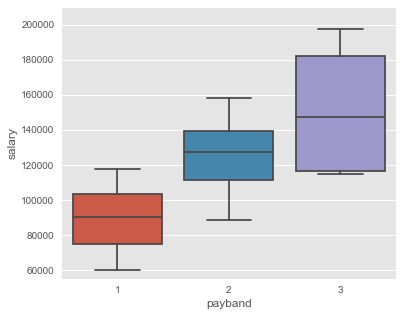

In [11]:
g = sns.boxplot(x='payband', y='salary', data=df)
g.set_ylim(55000, 210000)

## Random number generation

In [12]:
# Generate random number according to the specified probability distribution
def _generate_random(n=1):
    r_n = npr.choice(3, n, p=[.25, .65, .10])
    return r_n + 1

In [13]:
# Assign random group
df['random_group'] = _generate_random(n_recs)
df[:5]

,name,hire_date,payband,salary,fte,random_group
emp_id,,,,,,
1,"Williams, Bradley",2004-04-30,1,112489,1.0,1
2,"Santos, Jared",2015-09-27,1,65684,1.0,3
3,"Mendoza, Edward",2008-01-25,1,69203,1.0,1
4,"Kaiser, Kimberly",2003-04-23,1,105290,1.0,2
5,"Henry, Mallory",1975-08-16,1,103417,1.0,2


In [14]:
group_totals = df.groupby('random_group')['salary'].aggregate({'total': np.size})
group_totals['percent'] = group_totals.total/sum(group_totals.total)
group_totals

,total,percent
random_group,,
1,29,0.263636
2,70,0.636364
3,11,0.100000


## Pay uplift

### New pay ranges

In [15]:
new_ranges = pd.DataFrame({
    'payband': [1, 2, 3],
    'min': [69000, 87000, 105000],
    'max': [118000, 163000, 208100]
    })
new_ranges.set_index('payband', inplace=True)
new_ranges['midpoint'] = (new_ranges['max'] + new_ranges['min']) / 2
new_ranges

,max,min,midpoint
payband,,,
1,118000,69000,93500.0
2,163000,87000,125000.0
3,208100,105000,156550.0


### Uplift to new min
Everyone is eligible

In [16]:
def _apply_pay_uplift(row):
    pb = int(row.payband)
    new_min = new_ranges.ix[pb, 'min']
    if new_min > row.salary:
        return new_min - row.salary
    else:
        return 0

In [17]:
# Create new salary column 
temp_df = df.copy()
temp_df['uplift'] = temp_df.apply(_apply_pay_uplift, axis=1)
df = temp_df

### Calculate cost of uplift

In [18]:
'Cost of uplift: £{:,}'.format(sum(df.uplift))

'Cost of uplift: £67,606'

In [19]:
'Cost of uplift: {:,}%'.format((sum(df.uplift) / sum(df.salary)) * 100)

'Cost of uplift: 0.6216429318529246%'

### Analyse changes in salary distribution

In [20]:
df.groupby(['payband'])['salary','fte'].aggregate({'salary': [np.sum, np.min, np.max, np.mean, np.median],
                                                      'fte': [np.sum, 'count']})

salary                                   fte      
             sum    amin    amax    mean  median   sum count
payband                                                     
1        7192863   60082  117398   88800   90495  79.4    81
2        3076224   88560  158144  123048  127237  24.8    25
3         606288  114863  197429  151572  146998   4.0     4

In [24]:
#df.groupby(['payband'])['new_salary','fte'].aggregate({'new_salary': [np.sum, np.min, np.max, np.mean, np.median],
#                                                              'fte': [np.sum, 'count']})

## Pay options

In [25]:
total_paybill = sum(df['salary']) # estimated
eligibility_date = isodate.parse_date('2017-01-01')
option_df = pd.DataFrame({
    'breakpoint': [80000, 110000, 135000],
    'special_cases': [10, 5, 0],
    'special_award': [2000, 2000, 0],
    'pay_award_tier1': [1000, 1000, 1000],
    'pay_award_tier2': [250, 250, 250]
}, index=[1, 2, 3])
option_df.index.name = 'payband'

In [26]:
option_df

,breakpoint,pay_award_tier1,pay_award_tier2,special_award,special_cases
payband,,,,,
1,80000,1000,250,2000,10
2,110000,1000,250,2000,5
3,135000,1000,250,0,0


In [27]:
def pay_award(row):
    pb = row.payband
    if ((row.hire_date < pd.to_datetime(eligibility_date)) & (row.random_group < 3)):
        if row.salary < option_df.ix[pb, 'breakpoint']:
            return option_df.ix[pb, 'pay_award_tier1']
        else:
            return option_df.ix[pb, 'pay_award_tier2']

In [28]:
award_df = df.copy()
award_df['pay_award'] = award_df.apply(pay_award, axis=1)

In [29]:
award_df[:5]

,name,hire_date,payband,salary,fte,random_group,uplift,pay_award
emp_id,,,,,,,,
1,"Williams, Bradley",2004-04-30,1,112489,1.0,1,0,250.0
2,"Santos, Jared",2015-09-27,1,65684,1.0,3,3316,NaN
3,"Mendoza, Edward",2008-01-25,1,69203,1.0,1,0,1000.0
4,"Kaiser, Kimberly",2003-04-23,1,105290,1.0,2,0,250.0
5,"Henry, Mallory",1975-08-16,1,103417,1.0,2,0,250.0


In [30]:
# Fill N/A's with 0 to enable totals
award_df.fillna(value=0, inplace=True)
award_df['new_salary'] = award_df['salary'] + award_df['pay_award'] + award_df['uplift']

In [31]:
'Cost of award: {:,}%'.format(award_df['new_salary'].sum() / award_df['salary'].sum())

'Cost of award: 1.0107450087928003%'

In [32]:
'Cost of award: £{:,}'.format(sum(award_df.new_salary - award_df.salary))

'Cost of award: £116,856.0'

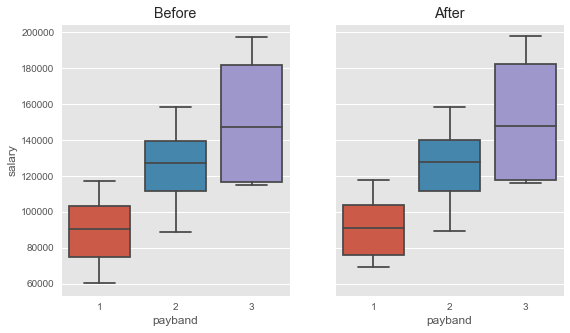

In [104]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(9,5))
sns.boxplot(x='payband', y='salary', data=df, ax=ax1)
ax1.set_title('Before')
sns.boxplot(x='payband', y='new_salary', data=award_df, ax=ax2)
ax2.set_title('After')
ax2.set_ylabel('')

# Monte-Carlo Simulation

In [121]:
%load_ext Cython

In [142]:
def run_simulation(df, option_df, paybill=None, N=100):
    n_recs = len(df)
    if paybill:
        paybill = paybill
    else:
        paybill = df['salary'].sum()
    results = []
    
    for i in range(N):
        df['random_group'] = _generate_random(n_recs)
        
        model_distribution = df.groupby('random_group')['salary'].aggregate({'total': np.size})
        model_distribution['percent'] = model_distribution.total/sum(model_distribution.total)
        
        # Apply uplift to new mins
        temp_df = df.copy()
        temp_df['uplift'] = temp_df.apply(_apply_pay_uplift, axis=1)
        df = temp_df
        
        # Apply pay awards
        award_df = df.copy()
        df['pay_award'] = award_df.apply(pay_award, axis=1)
        
        # Fill N/A's with 0 to enable totals
        df.fillna(value=0, inplace=True)
        df['new_salary'] = df['salary'] + df['pay_award'] + df['uplift']
        
        costs = sum(df['new_salary'] - df['salary'])
        
        results.append({
            'group1': model_distribution.ix[1,'percent'],
            'group2': model_distribution.ix[2,'percent'],
            'group3': model_distribution.ix[3,'percent'],
            'pay_costs': costs,
            'percent': (costs / paybill) * 100
        })
        
    return results

In [143]:
%%time
source_df = load_data(n_recs=110)
output = run_simulation(source_df, option_df, N=500)

CPU times: user 22.5 s, sys: 58.8 ms, total: 22.6 s
Wall time: 22.6 s


In [144]:
results_df = pd.DataFrame(output)
results_df = results_df.round(2)

In [145]:
results_df.mean()

group1            0.24814
group2            0.65206
group3            0.09934
pay_costs    131613.50000
percent           1.21272
dtype: float64

In [146]:
results_df.sample(15)

,group1,group2,group3,pay_costs,percent
55,0.28,0.65,0.07,132639.0,1.22
32,0.29,0.61,0.10,131889.0,1.22
198,0.18,0.71,0.11,130889.0,1.21
64,0.25,0.67,0.08,132389.0,1.22
212,0.25,0.68,0.06,132139.0,1.22
493,0.25,0.65,0.10,132639.0,1.22
78,0.28,0.59,0.13,130389.0,1.20
156,0.16,0.75,0.09,132889.0,1.22
420,0.26,0.59,0.15,127639.0,1.18
232,0.29,0.65,0.05,133889.0,1.23
